## TODO

Try flow MNIST with UNet MLP, UNet / DiT

In [ ]:
import math
import numpy as np
import torch
import torch.utils.checkpoint
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm.auto import tqdm

from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.utils import match_dim_with_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## Load dataset

In [ ]:
batch_size = 512

transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose(transform_list)
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,          
    pin_memory=True,
    persistent_workers=False,
)

batch = next(iter(train_dataloader))
print(batch[0].shape)  # torch.Size([256, 1, 28, 28])

## Train Unconditional Generation

In [ ]:
model_type = "unet"    # "mlp" or "unet" or "dit"
from rectified_flow.models.enhanced_mlp import VarMLP
from rectified_flow.models.utils import EMAModel

if model_type == "mlp":
    from rectified_flow.models.enhanced_mlp import MLPVelocity
    flow_model = MLPVelocity(
        dim=28*28,
        encoder_dims=[256, 512, 512],
        decoder_dims=[512, 512, 256],
        time_emb_dim = 512,
    )
    data_shape = (28*28,)
elif model_type == "unet":
    from rectified_flow.models.unet import SongUNet, SongUNetConfig
    config = SongUNetConfig(
        img_resolution = 28,
        in_channels = 1,                  # Number of color channels at input.
        out_channels = 1,                 # Number of color channels at output.
        label_dim = 0,                    # Number of class labels, 0 = unconditional.
        augment_dim = 0,                  # Augmentation label dimensionality, 0 = no augmentation.

        model_channels = 64,                # Base multiplier for the number of channels.
        channel_mult = [2, 2],              # Channel multipliers for each resolution.
        channel_mult_emb = 2,               # Multiplier for the dimensionality of the embedding vector.
        num_blocks = 2,                     # Number of residual blocks per resolution.
        attn_resolutions = [14],            # Resolutions at which to apply attention.
        dropout = 0.13,                     # Dropout probability of intermediate activations.
        label_dropout = 0.0,                # Dropout probability of class labels for classifier-free guidance.
        embedding_type = "positional",      # Timestep embedding type: 'positional' or 'fourier'.
        channel_mult_time = 1,              # Timestep embedding size: 1 for DDPM++, 2 for NCSN++.
        encoder_type = "standard",          # Encoder architecture: 'standard' or 'residual'.
        decoder_type = "standard",          # Decoder architecture: 'standard' or 'residual'.
        resample_filter = [1, 1]
    )

    # config = SongUNetConfig(
    #     img_resolution=28,
    #     in_channels=1,
    #     out_channels=1,
    #     label_dim=0,
    #     augment_dim=0,
    #     model_channels=128,
    #     channel_mult=[2, 2, 2],
    #     channel_mult_emb=4,
    #     num_blocks=4,
    #     attn_resolutions=[14],
    #     dropout=0.13,
    #     label_dropout=0.0,
    #     embedding_type="positional",
    #     channel_mult_time=1,
    #     encoder_type="standard",
    #     decoder_type="standard",
    #     resample_filter=[1, 1],
    # )
    flow_model = SongUNet(config)
    data_shape = (1, 28, 28)
elif model_type == "dit":
    raise NotImplementedError
else:
    raise ValueError(f"Unknown model type: {model_type}")

logvar = VarMLP().to(device)
flow_model = flow_model.to(device)

print(f"Number of parameters in flow model: {sum(p.numel() for p in flow_model.parameters() if p.requires_grad):,}")

ema_flow = EMAModel(flow_model, ema_halflife_kimg=1.0, ema_rampup_ratio=0.05)

optimizer = torch.optim.AdamW(
    list(flow_model.parameters()) + list(logvar.parameters()),
    lr=5e-4, weight_decay=0.01,
    betas=(0.9, 0.95)
)

compiled_flow = torch.compile(flow_model, mode="reduce-overhead", fullgraph=False, dynamic=False)
compiled_logvar = torch.compile(logvar, mode="reduce-overhead", fullgraph=False, dynamic=False)

compiled_flow.train(); compiled_logvar.train()
optimizer.zero_grad()

In [ ]:
epoch = 200
cur_nimg = 0

rf_train = RectifiedFlow(
    data_shape=data_shape,
    velocity_field=compiled_flow,
    train_time_distribution="uniform",
    device=device,
)

try:
    from tqdm.auto import tqdm
except Exception:
    from tqdm import tqdm

def safe_tqdm_write(msg: str):
    try:
        tqdm.write(msg)
    except Exception:
        print(msg)

zero_to_none = True
grad_clip_norm = None

global_step = 0
running_loss = None
smooth_alpha = 0.99

# test model
with torch.no_grad():
    batch = next(iter(train_dataloader))
    x_1, c = batch
    x_1 = x_1.to(device, non_blocking=True).reshape(x_1.shape[0], *data_shape)
    x_0 = torch.randn_like(x_1)
    t = rf_train.sample_train_time(x_1.shape[0]).to(device, non_blocking=True)
    v_pred = flow_model(x_1, t)
    print(x_1.shape, x_0.shape, v_pred.shape)
    log_var = logvar(t)[:, None, None, None]  # [B] or [B,1]
    denom = torch.exp(log_var)
    print(log_var.shape, denom.shape)
    sq_err = (v_pred - (x_1 - x_0)).pow(2).sum(dim=1)
    loss = (sq_err / denom + log_var).mean()
    safe_tqdm_write(f"Initial test loss: {loss.item():.4f}")

In [ ]:
for ep in tqdm(range(epoch), desc="Epochs", position=0):
    pbar = tqdm(train_dataloader, desc=f"ep {ep+1}/{epoch}", leave=False, position=1)
    for step, batch in enumerate(pbar):
        optimizer.zero_grad(set_to_none=zero_to_none)

        x_1, c = batch
        x_1 = x_1.to(device, non_blocking=True).reshape(x_1.shape[0], *data_shape)
        x_0 = torch.randn_like(x_1)
        t = rf_train.sample_train_time(x_1.shape[0]).to(device, non_blocking=True)

        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            x_t, dot_x_t = rf_train.get_interpolation(x_0=x_0, x_1=x_1, t=t)
            v_pred = rf_train.get_velocity(x_t, t)
            log_var = compiled_logvar(t)
            log_var = log_var[:, None, None, None]

        mse_loss = torch.nn.functional.mse_loss(v_pred.detach(), dot_x_t.detach()).item()
        denom = torch.exp(log_var)
        sq_err = (v_pred - dot_x_t).pow(2).sum(dim=1)
        loss = (sq_err / denom + log_var).mean()

        loss.backward()

        if grad_clip_norm is not None:
            torch.nn.utils.clip_grad_norm_(rf_train.parameters(), grad_clip_norm)

        optimizer.step()

        global_step += 1
        cur_nimg += x_1.shape[0]
        ema_flow.update(cur_nimg=cur_nimg, batch_size=x_1.shape[0])

        loss_val = float(loss.detach().item())
        running_loss = loss_val if running_loss is None else smooth_alpha * running_loss + (1 - smooth_alpha) * mse_loss

        pbar.set_postfix({
            "mse_loss": f"{mse_loss:.4f}",
            "mse_loss_ema": f"{running_loss:.4f}",
            "logvar_loss": f"{loss_val:.4f}",
            "steps": global_step
        })

    safe_tqdm_write(f"[epoch {ep+1}/{epoch}] steps={global_step:,} mse_loss={mse_loss:.4f}, mse_loss_ema={running_loss:.4f}, logvar_loss={loss_val:.4f}")

    if ep % 10 == 0:
        flow_model.save_pretrained(f"./checkpoints/flow_mnist")
        ema_flow.save_pretrained(f"./checkpoints/flow_mnist")

print(f"Training done. Total steps: {global_step:,}, last loss: {loss_val:.4f}, EMA: {running_loss:.4f}")

In [ ]:
# Plot log var
time = torch.linspace(0, 1, steps=1000).to(device)
with torch.no_grad():
    log_var_vals = compiled_logvar(time).cpu().numpy()
plt.figure(figsize=(6,4))
plt.plot(time.cpu().numpy(), log_var_vals)
plt.title("Log Variance Schedule")
plt.xlabel("Time")
plt.ylabel("Log Variance")
plt.grid()
plt.show()

In [ ]:
from rectified_flow.samplers import EulerSampler, SDESampler

ema_flow.apply_shadow()
model_inference = flow_model.eval()

rf_inference = RectifiedFlow(
    data_shape=data_shape,
    velocity_field=model_inference,
    device=device,
)

euler_sampler = EulerSampler(rf_inference, num_steps=200)
sde_sampler = SDESampler(rf_inference, num_steps=200, noise_scale=5, noise_decay_rate=0.)

In [ ]:
x_0 = torch.randn(30, *data_shape).to(device) * 0.5

x_1_euler = euler_sampler.sample_loop(x_0=x_0).trajectories[-1]
x_1_sde = sde_sampler.sample_loop(x_0=x_0).trajectories[-1]

print(x_1.shape)  # torch.Size([20, 1, 28, 28])

In [ ]:
from rectified_flow.utils import plot_cifar_results

plot_cifar_results(x_1_euler)
plot_cifar_results(x_1_sde)

In [ ]:
N = 1000
bs = x_1_euler.shape[0]

x_t_euler = x_1_euler.clone()
x_t_sde = x_1_sde.clone()

with torch.inference_mode():
    for i in range(N):
        t = 1. - i / N
        v_pred_euler = model_inference(x_t_euler, torch.full((bs,), t, device=device))
        v_pred_sde = model_inference(x_t_sde, torch.full((bs,), t, device=device))
        
        x_t_euler = x_t_euler - v_pred_euler / N
        x_t_sde = x_t_sde - v_pred_sde / N

plot_cifar_results(x_0)
plot_cifar_results(x_t_euler)
# plot_cifar_results(torch.abs(x_0 - x_t_euler))
plot_cifar_results(x_t_sde)
# plot_cifar_results(torch.abs(x_0 - x_t_sde))

x0_inv_euler = x_t_euler.detach().reshape(bs, -1)
x0_inv_sde   = x_t_sde.detach().reshape(bs, -1)

# Plot the norm of x_0_inv
norms_euler = x0_inv_euler.norm(dim=1).cpu().numpy()
norms_sde   = x0_inv_sde.norm(dim=1).cpu().numpy()

lo = float(min(norms_euler.min(), norms_sde.min()))
hi = float(max(norms_euler.max(), norms_sde.max()))
bins = np.linspace(lo, hi, 100)  # 同数量 & 边界

plt.figure(figsize=(6,4), dpi=300)
plt.hist(norms_euler, bins=bins, density=True, alpha=0.6,
         label='Euler', edgecolor='black', linewidth=0.6)
plt.hist(norms_sde,   bins=bins, density=True, alpha=0.6,
         label='SDE',   edgecolor='black', linewidth=0.6)
plt.xlabel(r'$\,\|x_0^{\mathrm{inv}}\|_2$')
plt.ylabel('Density')
plt.title('Recovered noise L2-norm distribution')
plt.legend()
plt.tight_layout()
plt.show()

with torch.inference_mode():
    for i in range(N):
        t = i / N

        v_pred_euler = model_inference(x_t_euler, torch.full((bs,), t, device=device))
        v_pred_sde = model_inference(x_t_sde, torch.full((bs,), t, device=device))

        x_t_euler = x_t_euler + v_pred_euler / N
        x_t_sde = x_t_sde + v_pred_sde / N

plot_cifar_results(x_t_euler)
plot_cifar_results(x_t_sde)

## Train Conditional Generation

In [ ]:
model_type = "unet"    # "mlp" or "unet" or "dit"
from rectified_flow.models.enhanced_mlp import VarMLP
from rectified_flow.models.utils import EMAModel

if model_type == "mlp":
    from rectified_flow.models.enhanced_mlp import MLPVelocity
    flow_model = MLPVelocity(
        dim=28*28,
        encoder_dims=[256, 512, 512],
        decoder_dims=[512, 512, 256],
        time_emb_dim = 512,
    )
    data_shape = (28*28,)
elif model_type == "unet":
    from rectified_flow.models.unet import SongUNet, SongUNetConfig
    config = SongUNetConfig(
        img_resolution = 28,
        in_channels = 1,                  # Number of color channels at input.
        out_channels = 1,                 # Number of color channels at output.
        label_dim = 10,                   # Number of class labels, 0 = unconditional.
        augment_dim = 0,                  # Augmentation label dimensionality, 0 = no augmentation.

        model_channels = 64,                # Base multiplier for the number of channels.
        channel_mult = [2, 2],              # Channel multipliers for each resolution.
        channel_mult_emb = 2,               # Multiplier for the dimensionality of the embedding vector.
        num_blocks = 2,                     # Number of residual blocks per resolution.
        attn_resolutions = [14],            # Resolutions at which to apply attention.
        dropout = 0.13,                     # Dropout probability of intermediate activations.
        label_dropout = 0.1,                # Dropout probability of class labels for classifier-free guidance.
        embedding_type = "positional",      # Timestep embedding type: 'positional' or 'fourier'.
        channel_mult_time = 1,              # Timestep embedding size: 1 for DDPM++, 2 for NCSN++.
        encoder_type = "standard",          # Encoder architecture: 'standard' or 'residual'.
        decoder_type = "standard",          # Decoder architecture: 'standard' or 'residual'.
        resample_filter = [1, 1]
    )

    # config = SongUNetConfig(
    #     img_resolution=28,
    #     in_channels=1,
    #     out_channels=1,
    #     label_dim=0,
    #     augment_dim=0,
    #     model_channels=128,
    #     channel_mult=[2, 2, 2],
    #     channel_mult_emb=4,
    #     num_blocks=4,
    #     attn_resolutions=[14],
    #     dropout=0.13,
    #     label_dropout=0.0,
    #     embedding_type="positional",
    #     channel_mult_time=1,
    #     encoder_type="standard",
    #     decoder_type="standard",
    #     resample_filter=[1, 1],
    # )
    flow_model = SongUNet(config)
    data_shape = (1, 28, 28)
elif model_type == "dit":
    raise NotImplementedError
else:
    raise ValueError(f"Unknown model type: {model_type}")

logvar = VarMLP().to(device)
flow_model = flow_model.to(device)

print(f"Number of parameters in flow model: {sum(p.numel() for p in flow_model.parameters() if p.requires_grad):,}")

ema_flow = EMAModel(flow_model, ema_halflife_kimg=1.0, ema_rampup_ratio=0.05)

optimizer = torch.optim.AdamW(
    list(flow_model.parameters()) + list(logvar.parameters()),
    lr=5e-4, weight_decay=0.01,
    betas=(0.9, 0.95)
)

compiled_flow = torch.compile(flow_model, mode="reduce-overhead", fullgraph=False, dynamic=False)
compiled_logvar = torch.compile(logvar, mode="reduce-overhead", fullgraph=False, dynamic=False)

compiled_flow.train(); compiled_logvar.train()
optimizer.zero_grad()

In [ ]:
epoch = 200
cur_nimg = 0

rf_train = RectifiedFlow(
    data_shape=data_shape,
    velocity_field=compiled_flow,
    train_time_distribution="uniform",
    device=device,
)

try:
    from tqdm.auto import tqdm
except Exception:
    from tqdm import tqdm

def safe_tqdm_write(msg: str):
    try:
        tqdm.write(msg)
    except Exception:
        print(msg)

zero_to_none = True
grad_clip_norm = None

global_step = 0
running_loss = None
smooth_alpha = 0.99

# test model
with torch.no_grad():
    batch = next(iter(train_dataloader))
    x_1, c = batch
    x_1 = x_1.to(device, non_blocking=True).reshape(x_1.shape[0], *data_shape)
    c = c.to(device, non_blocking=True)
    c_onehot = torch.nn.functional.one_hot(c, num_classes=10).float()
    x_0 = torch.randn_like(x_1)
    t = rf_train.sample_train_time(x_1.shape[0]).to(device, non_blocking=True)
    # print(x_1.shape, x_0.shape, c.shape, t.shape)
    v_pred = flow_model(x_1, t, c_onehot)
    log_var = logvar(t)[:, None, None, None]  # [B] or [B,1]
    denom = torch.exp(log_var)
    print(log_var.shape, denom.shape)
    sq_err = (v_pred - (x_1 - x_0)).pow(2).sum(dim=1)
    loss = (sq_err / denom + log_var).mean()
    safe_tqdm_write(f"Initial test loss: {loss.item():.4f}")

In [ ]:
for ep in tqdm(range(epoch), desc="Epochs", position=0):
    pbar = tqdm(train_dataloader, desc=f"ep {ep+1}/{epoch}", leave=False, position=1)
    for step, batch in enumerate(pbar):
        optimizer.zero_grad(set_to_none=zero_to_none)

        x_1, c = batch
        c_onehot = torch.nn.functional.one_hot(c, num_classes=10).float()
        c_onehot = c_onehot.to(device, non_blocking=True)
        x_1 = x_1.to(device, non_blocking=True).reshape(x_1.shape[0], *data_shape)
        x_0 = torch.randn_like(x_1)
        t = rf_train.sample_train_time(x_1.shape[0]).to(device, non_blocking=True)

        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            x_t, dot_x_t = rf_train.get_interpolation(x_0=x_0, x_1=x_1, t=t)
            v_pred = rf_train.get_velocity(x_t, t, class_labels=c_onehot)
            log_var = compiled_logvar(t)
            log_var = log_var[:, None, None, None]

        mse_loss = torch.nn.functional.mse_loss(v_pred.detach(), dot_x_t.detach()).item()
        denom = torch.exp(log_var)
        sq_err = (v_pred - dot_x_t).pow(2).sum(dim=1)
        loss = (sq_err / denom + log_var).mean()

        loss.backward()

        if grad_clip_norm is not None:
            torch.nn.utils.clip_grad_norm_(rf_train.parameters(), grad_clip_norm)

        optimizer.step()

        global_step += 1
        cur_nimg += x_1.shape[0]
        ema_flow.update(cur_nimg=cur_nimg, batch_size=x_1.shape[0])

        loss_val = float(loss.detach().item())
        running_loss = loss_val if running_loss is None else smooth_alpha * running_loss + (1 - smooth_alpha) * mse_loss

        pbar.set_postfix({
            "mse_loss": f"{mse_loss:.4f}",
            "mse_loss_ema": f"{running_loss:.4f}",
            "logvar_loss": f"{loss_val:.4f}",
            "steps": global_step
        })

    safe_tqdm_write(f"[epoch {ep+1}/{epoch}] steps={global_step:,} mse_loss={mse_loss:.4f}, mse_loss_ema={running_loss:.4f}, logvar_loss={loss_val:.4f}")

    if ep % 10 == 0:
        flow_model.save_pretrained(f"./checkpoints/flow_mnist_unet_conditional")
        ema_flow.save_pretrained(f"./checkpoints/flow_mnist_unet_conditional")

print(f"Training done. Total steps: {global_step:,}, last loss: {loss_val:.4f}, EMA: {running_loss:.4f}")

### Class Conditional Generation without CFG

In [ ]:
from rectified_flow.samplers import EulerSampler, SDESampler

flow_model = SongUNet.from_pretrained(f"./checkpoints/flow_mnist_unet_conditional", use_ema=False).to(device)

model_inference = flow_model.eval()

rf_inference = RectifiedFlow(
    data_shape=data_shape,
    velocity_field=model_inference,
    device=device,
)

# generate 100 samples for each class
class_labels = torch.arange(10, device=device)
class_labels = class_labels.repeat_interleave(10, dim=0)
class_onehot = torch.nn.functional.one_hot(class_labels, num_classes=10).float()

euler_sampler = EulerSampler(rf_inference, num_steps=50, num_samples=100)
sde_sampler = SDESampler(rf_inference, num_steps=50, noise_scale=50, noise_decay_rate=0., num_samples=100)

In [ ]:
x_1_euler = euler_sampler.sample_loop(seed=33, class_labels=class_onehot).trajectories[-1]
x_1_sde = sde_sampler.sample_loop(seed=33, class_labels=class_onehot).trajectories[-1]

print(x_1_euler.shape)  # torch.Size([20, 1, 28, 28])

In [ ]:
from rectified_flow.utils import plot_cifar_results

plot_cifar_results(x_1_euler)
plot_cifar_results(x_1_sde)

### Class Conditional Generation with CFG

In [60]:
from rectified_flow.samplers import EulerSampler, SDESampler

flow_model = SongUNet.from_pretrained(f"./checkpoints/flow_mnist_unet_conditional", use_ema=True).to(device)

model_inference = flow_model.eval()

def velocity_with_cfg(x, t, class_labels=None, cfg_scale=50.):
    assert class_labels is not None
    # get unconditional prediction
    v_uncond = model_inference(x, t, torch.zeros_like(class_labels))
    # get conditional prediction
    v_cond = model_inference(x, t, class_labels)

    return v_uncond + cfg_scale * (v_cond - v_uncond)

rf_inference = RectifiedFlow(
    data_shape=data_shape,
    velocity_field=velocity_with_cfg,
    device=device,
)

# generate 100 samples for each class
class_labels = torch.arange(10, device=device)
class_labels = class_labels.repeat_interleave(10, dim=0)
class_onehot = torch.nn.functional.one_hot(class_labels, num_classes=10).float()

euler_sampler = EulerSampler(rf_inference, num_steps=50, num_samples=100)
sde_sampler = SDESampler(rf_inference, num_steps=50, noise_scale=5, noise_decay_rate=0., num_samples=100)

Model loaded from ./checkpoints/flow_mnist_unet_conditional/unet_ema.pt


In [61]:
x_1_euler = euler_sampler.sample_loop(seed=33, class_labels=class_onehot).trajectories[-1]
x_1_sde = sde_sampler.sample_loop(seed=33, class_labels=class_onehot).trajectories[-1]

print(x_1_euler.shape)  # torch.Size([20, 1, 28, 28])

torch.Size([100, 1, 28, 28])


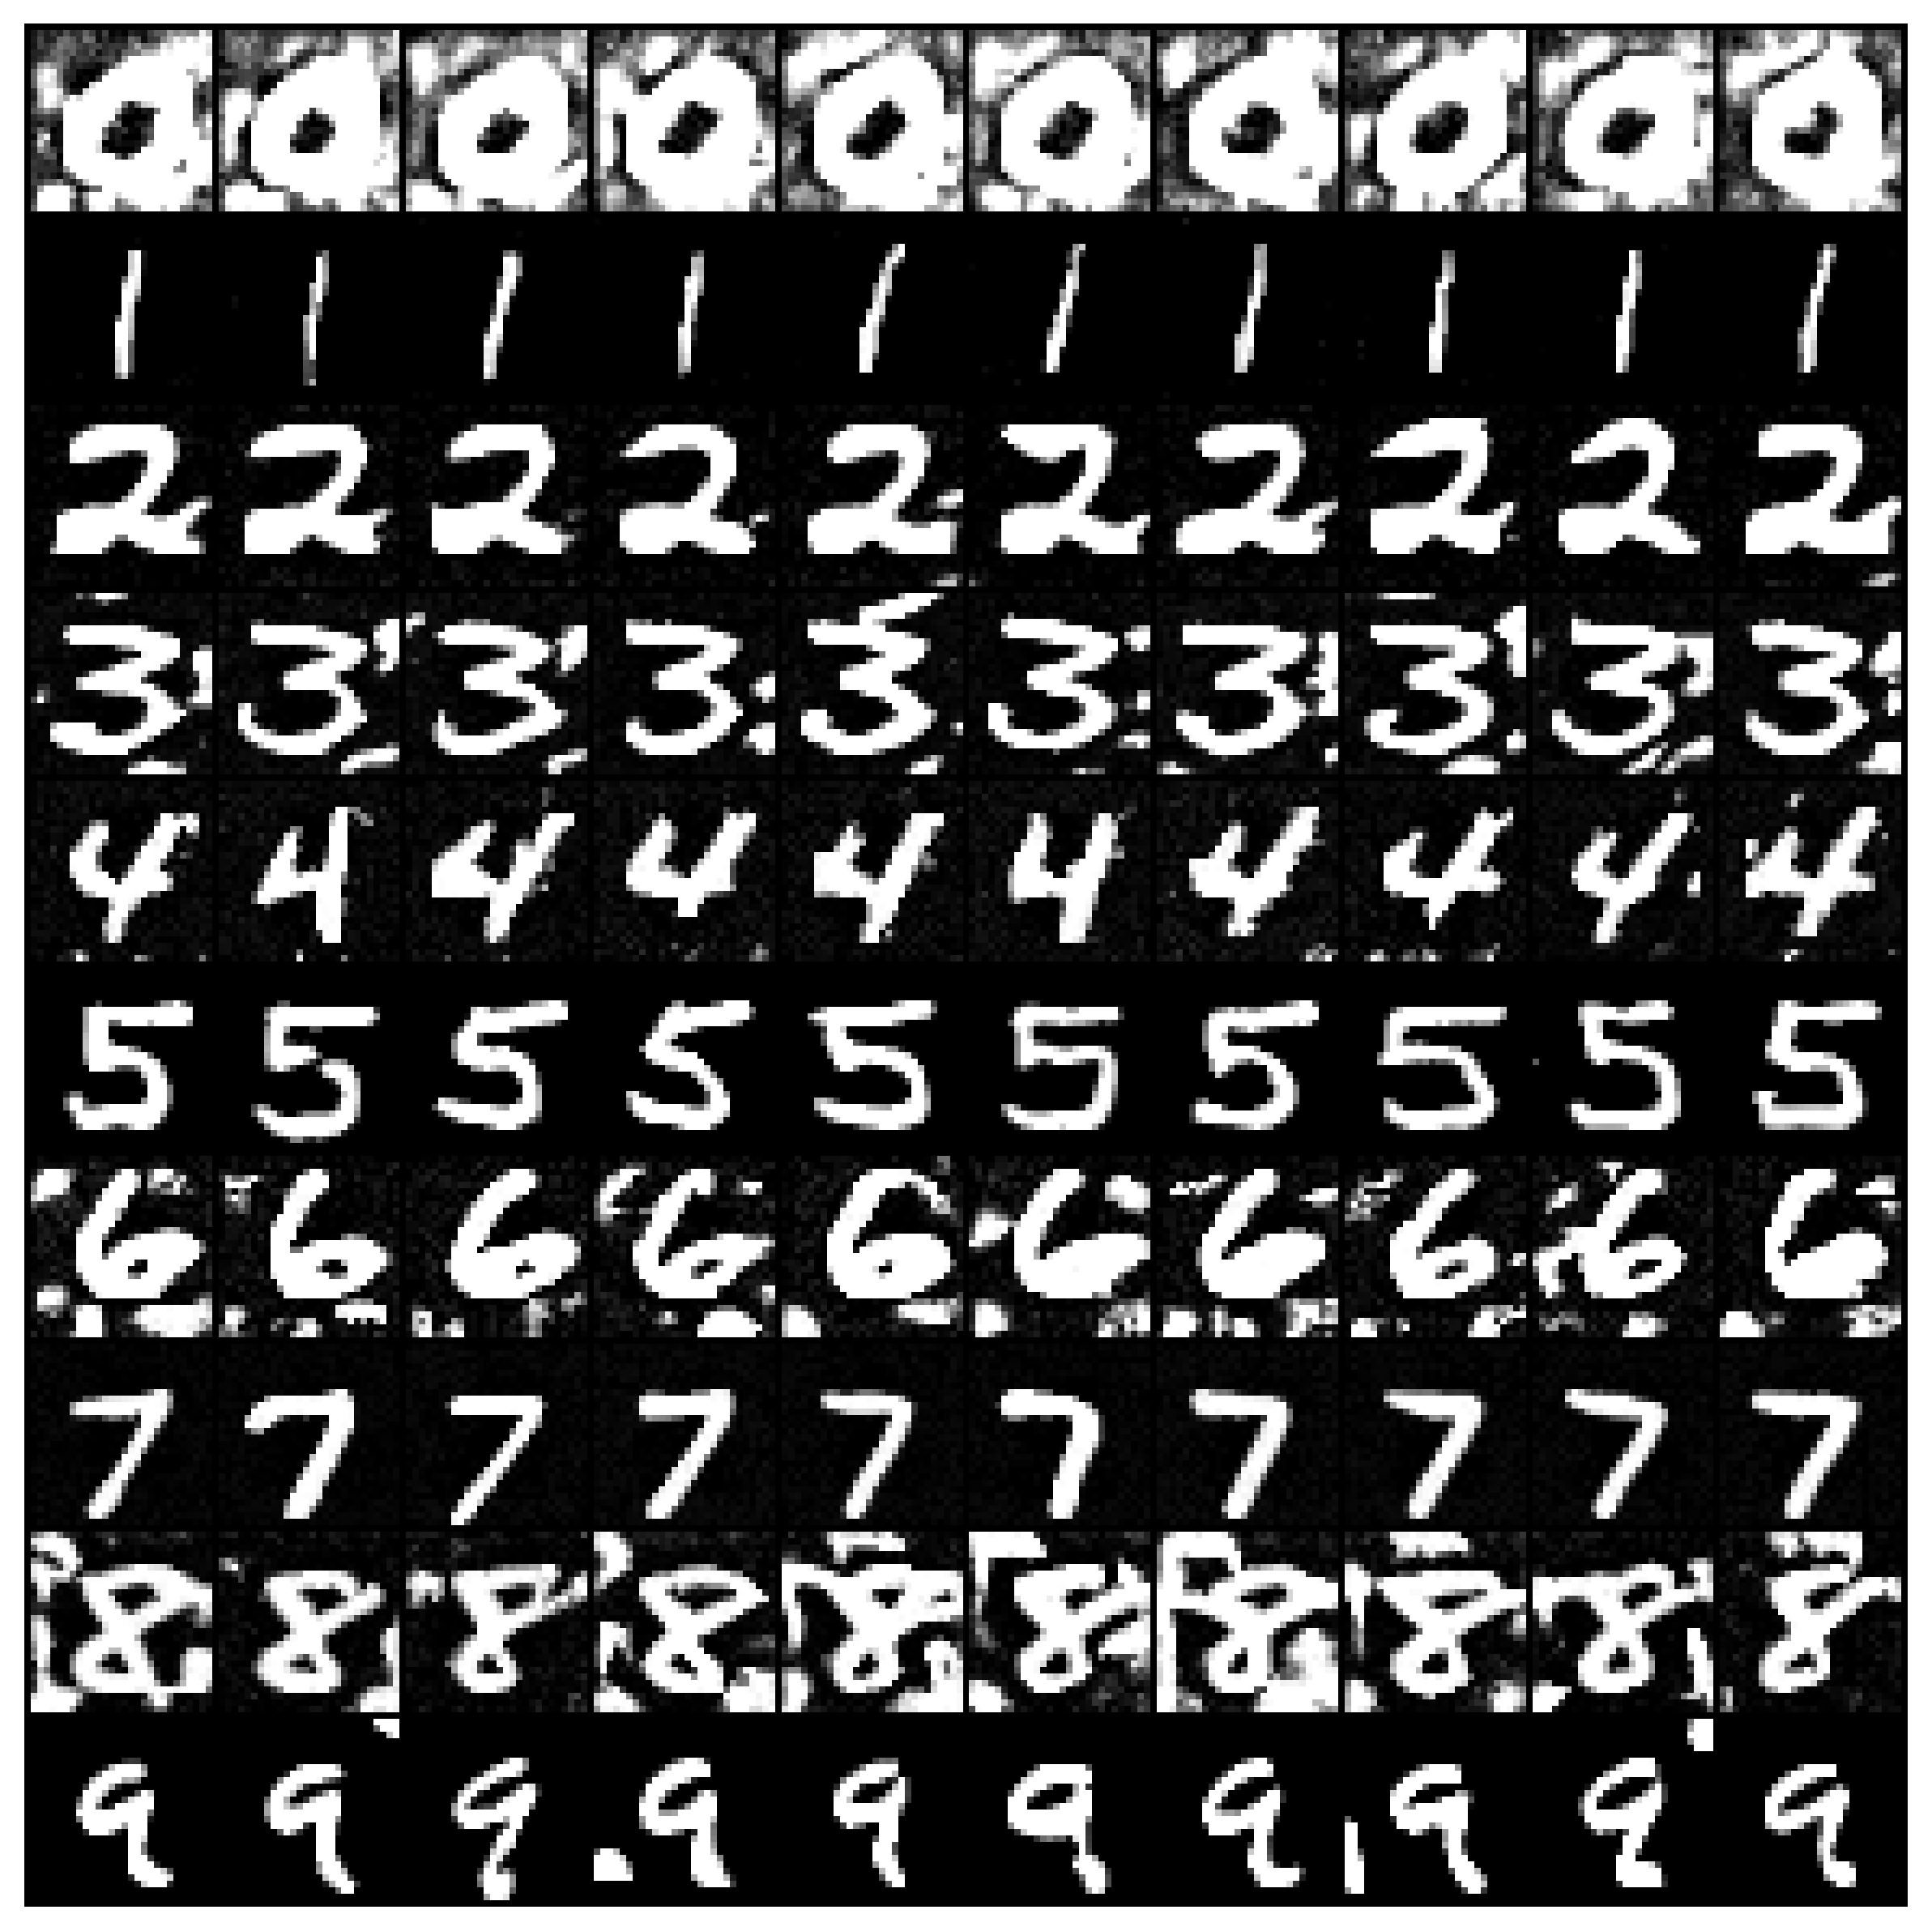

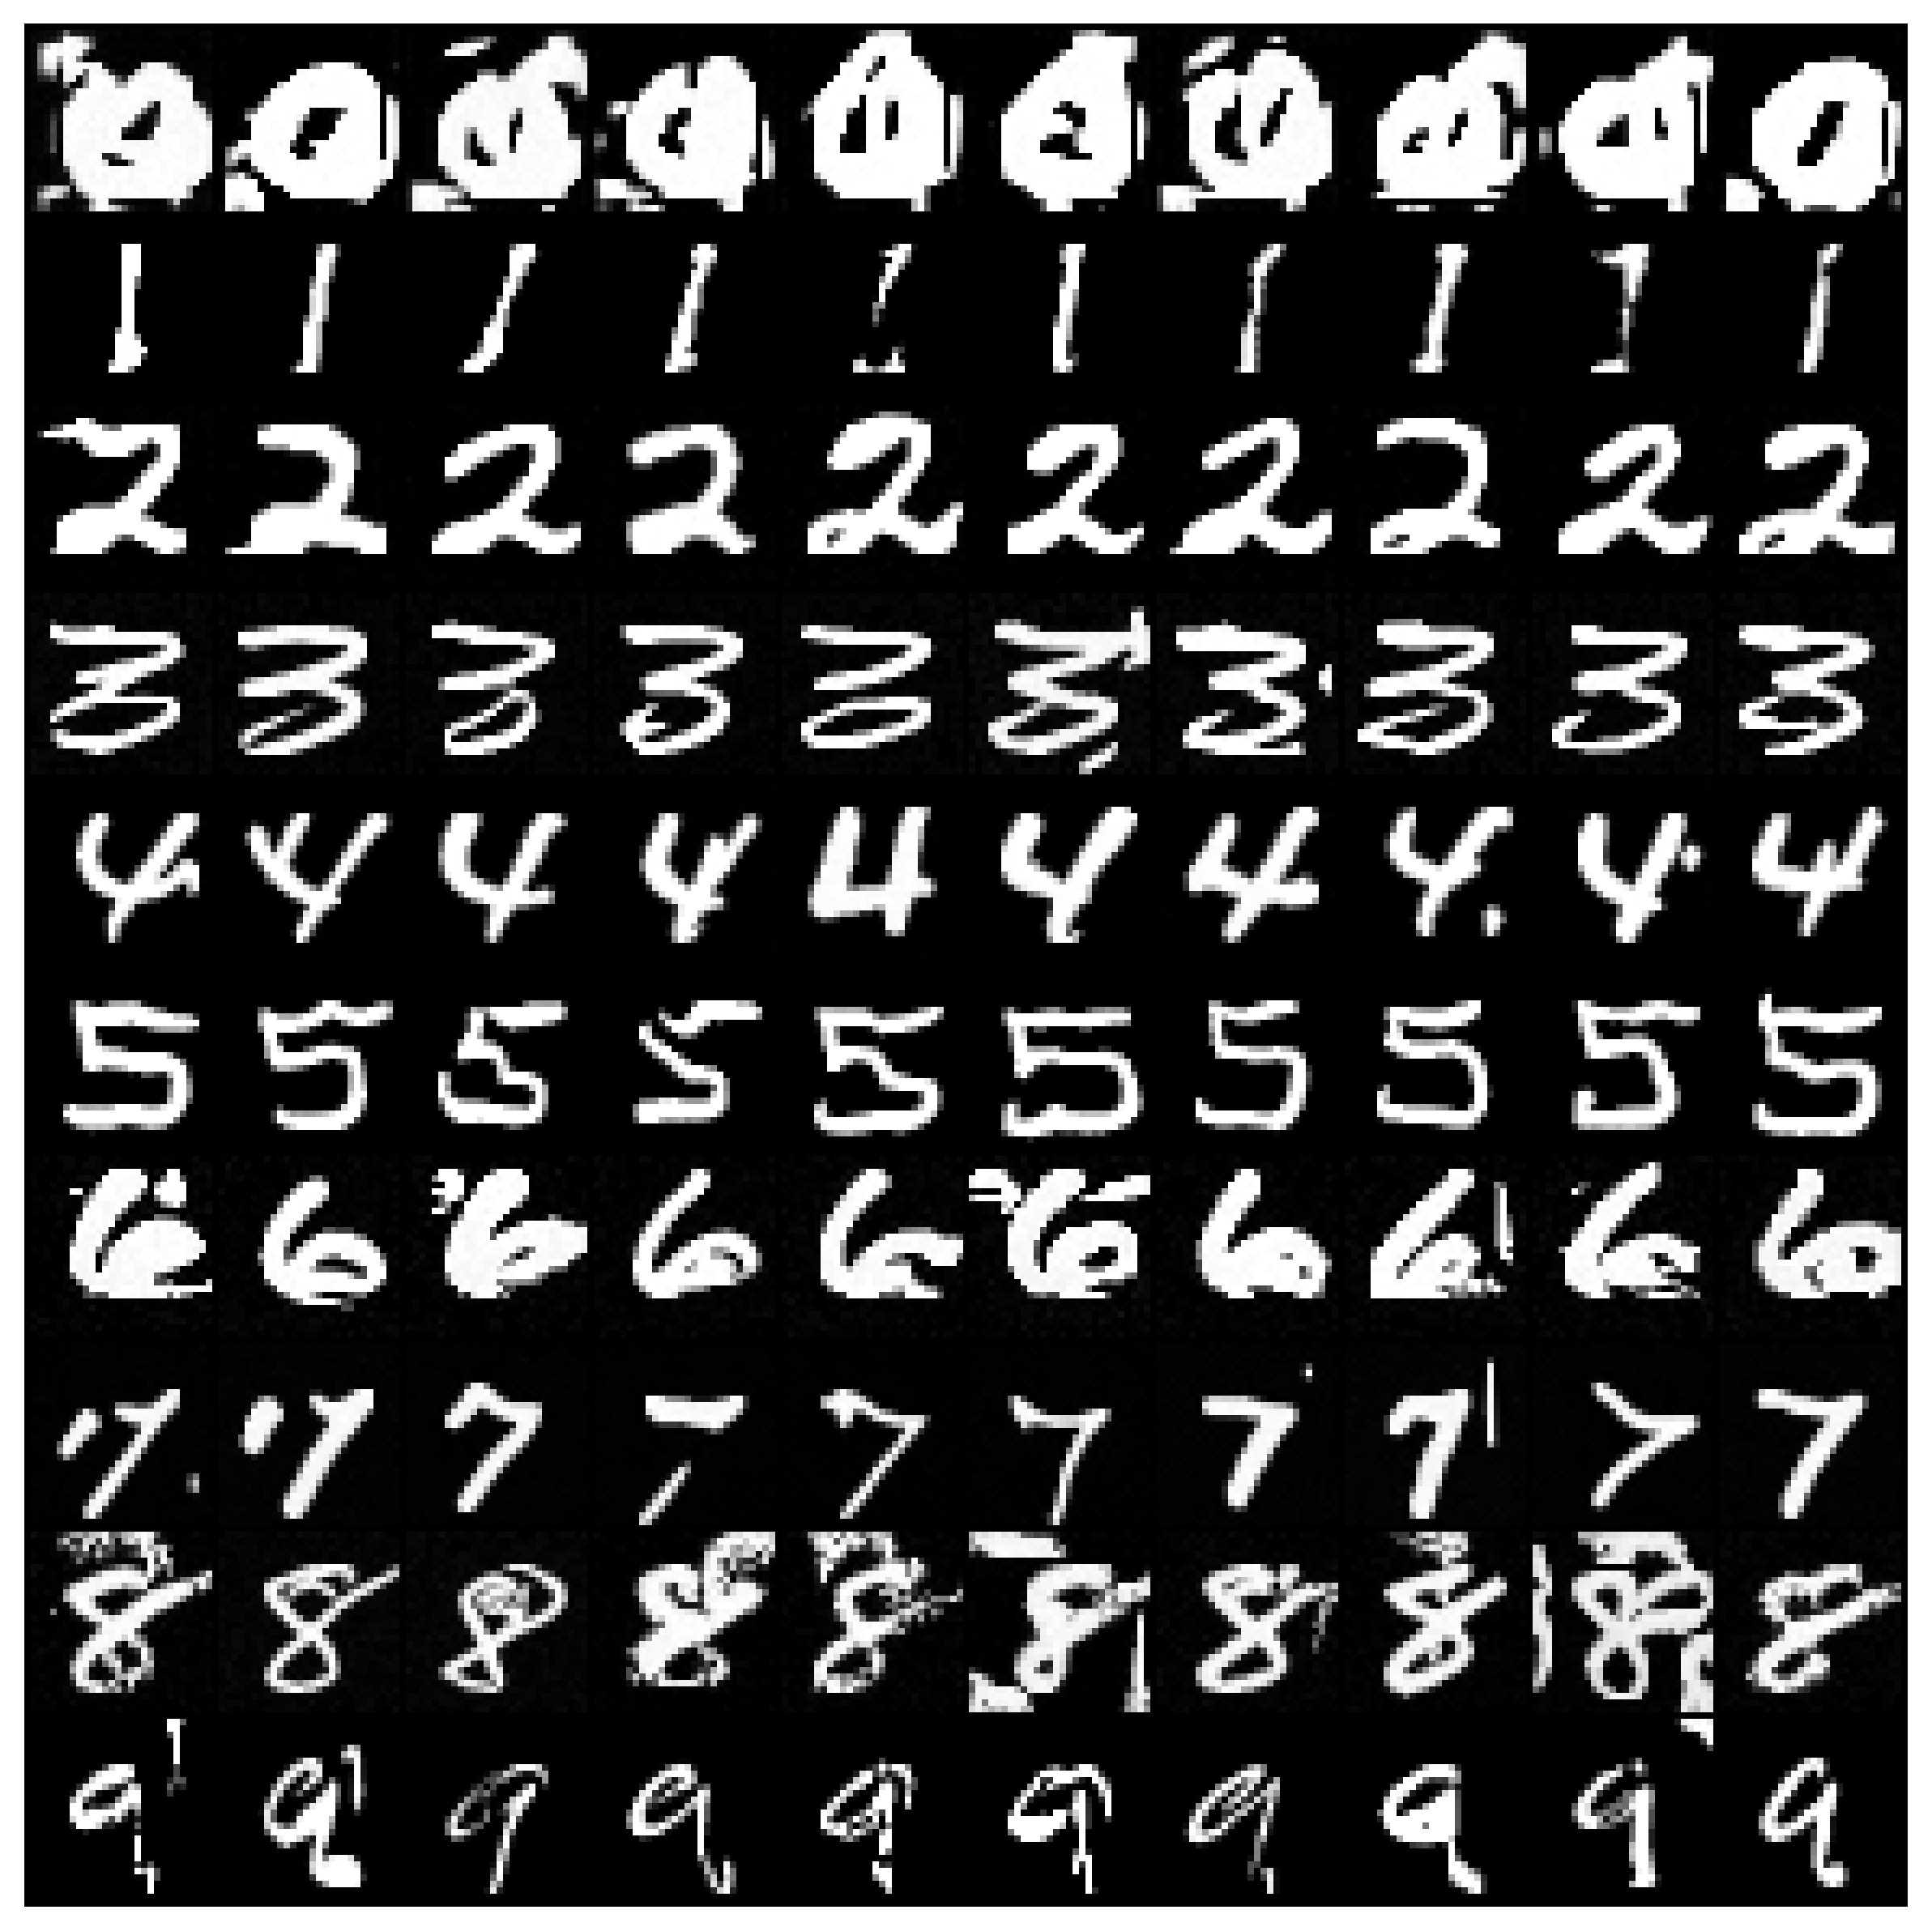

In [62]:
from rectified_flow.utils import plot_cifar_results

plot_cifar_results(x_1_euler)
plot_cifar_results(x_1_sde)